# 通过t-sne算法对模型的输出进行降维分析与可视化

## 1. 处理模型输出的文件

In [13]:
# 导入必要的库
import numpy as np
import pandas as pd
from Bio import SeqIO


family_list = ['PF00959','PF01832', 'PF05838', 'PF06737','PF16754']
# family_list = ['PF00959']
family_dict = {'PF00959':0, 'PF01832':1, 'PF05838':2, 'PF06737':3,'PF16754':4}

# 需要选择一定数量的序列，用作t-sne，否则大量的数据进行降维分析时，效果极差
# # 1
# natural_sample_num = {'PF00959':195, 'PF01832':300, 'PF05838':71, 'PF06737':137,'PF16754':58}
# generate_sample_num = {'PF00959':400, 'PF01832':600, 'PF05838':140, 'PF06737':300, 'PF16754':120}

# # 2
natural_sample_num = {'PF00959':190, 'PF01832':280, 'PF05838':70, 'PF06737':137,'PF16754':40}   # PF16754按照比例为4，但是效果不好，所以增加数量
sample_num = 500
generate_sample_num = {'PF00959':sample_num, 'PF01832':sample_num, 'PF05838':sample_num, 'PF06737':sample_num, 'PF16754':sample_num}

# # 3
# natural_sample_num = {'PF00959':190, 'PF01832':280, 'PF05838':70, 'PF06737':137,'PF16754':40}   # PF16754按照比例为4，但是效果不好，所以增加数量
# sample_num = 500
# generate_sample_num = {'PF00959':sample_num, 'PF01832':sample_num, 'PF05838':sample_num, 'PF06737':300, 'PF16754':120}


处理模型输出的序列

In [14]:
# 挑选模型困惑度较低的序列
# 因为困惑度越低越合理



sample_input_dir = "../dataset/lora_generation_dataset/"
sample_output_dir = "data/generation_samples/"
p = 0.5

for fn in family_list:
    code = family_dict[fn]
    input_filename = sample_input_dir+"9_samples_lora_code_"+str(code)+"_"+str(p)+".txt"
    df = pd.read_csv(input_filename, header=None, names=['sequence', 'score'])
    # 将 'score' 列转换为浮点数
    df['score'] = df['score'].astype(float)
    # 删除 'sequence' 列中长度大于510的项
    df_limit = df[df['sequence'].apply(lambda x: len(x) <= 510)]
    # 对 'score' 列进行升序排序
    df_sorted = df_limit.sort_values(by='score', ascending=True)
    # 删除 'sequence' 列中的重复项
    df_sorted_unique = df_sorted.drop_duplicates(subset='sequence')
    # 选择前n个数据
    df_top = df_sorted_unique.head(generate_sample_num[fn])
    # 保存到新的sample文件
    output_filename = sample_output_dir + fn + "_samples.txt"
    df_top['sequence'].to_csv(output_filename, index=False, header=False)
    print(f"{fn}家族选择的序列已经保存到文件{output_filename}中，共有{generate_sample_num[fn]}条序列。")



PF00959家族选择的序列已经保存到文件data/generation_samples/PF00959_samples.txt中，共有500条序列。
PF01832家族选择的序列已经保存到文件data/generation_samples/PF01832_samples.txt中，共有500条序列。
PF05838家族选择的序列已经保存到文件data/generation_samples/PF05838_samples.txt中，共有500条序列。
PF06737家族选择的序列已经保存到文件data/generation_samples/PF06737_samples.txt中，共有500条序列。
PF16754家族选择的序列已经保存到文件data/generation_samples/PF16754_samples.txt中，共有500条序列。


处理自然序列

In [15]:
sample_input_dir = "../dataset/lysozyme_dataset/"
sample_output_dir = "data/natural_samples/"

def read_seq_from_fasta(input_filename):
    sequences = []
    with open(input_filename, 'r') as file:
        for record in SeqIO.parse(file, 'fasta'):
            sequence = str(record.seq)
            sequences.append(sequence)
    return sequences

for fn in family_list:
    code = family_dict[fn]
    input_filename = sample_input_dir+fn+".fasta"
    sequences = read_seq_from_fasta(input_filename)
    # 保存到输出文件中
    output_filename = sample_output_dir + fn + "_samples.txt"
    # 将当前sequences写入output_filename文件中
    with open(output_filename, 'w') as file:
        for sequence in sequences[:natural_sample_num[fn]]:
            file.write(sequence + '\n')
    print(f"{fn}家族选择的序列已经保存到文件{output_filename}中，共有{len(sequences[:natural_sample_num[fn]])}条序列。")

PF00959家族选择的序列已经保存到文件data/natural_samples/PF00959_samples.txt中，共有190条序列。
PF01832家族选择的序列已经保存到文件data/natural_samples/PF01832_samples.txt中，共有280条序列。
PF05838家族选择的序列已经保存到文件data/natural_samples/PF05838_samples.txt中，共有70条序列。
PF06737家族选择的序列已经保存到文件data/natural_samples/PF06737_samples.txt中，共有137条序列。
PF16754家族选择的序列已经保存到文件data/natural_samples/PF16754_samples.txt中，共有40条序列。


## 2. 将挑选的序列嵌入为向量

In [16]:
# 利用训练好的分类模型，将已经选择的序列嵌入为向量
# 此处使用的是tape中的bert模型，为了得到序列的嵌入向量
# 为了探究序列的特征，我们将序列嵌入为向量，然后使用t-sne进行降维分析
# 在自然序列中，训练好的嵌入向量在t-sne后，图像将会呈现出5种聚类的效果
# 如果人工序列捕捉到了各个家族的特征，那么在t-sne后，图像中应该也会有5个聚类
# 执行当前代码，需要手动修改
import torch
import pandas as pd
import numpy as np
from tape import TAPETokenizer
from tape.models.modeling_bert import ProteinBertForSequenceClassification
from torch.utils.data import TensorDataset, SequentialSampler, DataLoader

tokenizer = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

max_seq_length = 256
batch_size = 32


device: cuda


将上述输出转化为嵌入向量

In [17]:
def read_seq_and_label_from_txt(filename, label):
    # 读取fasta文件并编码序列
    sequences = []
    labels = []
    df = pd.read_csv(filename, header=None, names=['sequence'])
    for seq in df['sequence']:
        sequences.append(seq)
        labels.append(label)
    return sequences, labels

def get_dataset(txt_path, label):
    # 将数据集分完词后存储到列表中
    all_input_ids = []
    attention_masks = []
    sentences, labels = read_seq_and_label_from_txt(txt_path, label)

    for sent in sentences:
        # 将文本转换为编码
        input_ids = tokenizer.encode(sent).tolist()
        # 如果编码后的文本长度大于最大长度，则截断
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[0:max_seq_length]
        # input_ids = [tokenizer.vocab['<cls>']] + input_ids + [tokenizer.vocab['<sep>']]

        # 获取mask
        pad_len = max_seq_length - len(input_ids)
        mask = torch.tensor([1] * max_seq_length)
        # 如果 pad_len 大于 0，说明文本长度小于最大长度，需要填充
        if pad_len > 0:
            input_ids = input_ids + [tokenizer.vocab['<pad>']] * pad_len
            mask[-pad_len:] = 0

        # 将编码后的文本加入到列表
        all_input_ids.append(input_ids)

        # 将文本的 attention mask 也加入到 attention_masks 列表
        attention_masks.append(mask.tolist())

    # 将列表转换为 tensor
    all_input_ids = torch.tensor(all_input_ids, dtype=torch.long)
    attention_masks = torch.tensor(attention_masks, dtype=torch.long)
    labels = torch.tensor(labels)
    # 创建一个 TensorDataset
    dataset = TensorDataset(all_input_ids, attention_masks, labels)
    return dataset

pfam = ['PF00959', 'PF01832', 'PF05838', 'PF06737', 'PF16754']
pfam_id = [0, 1, 2, 3, 4]

output_dir = '../tape-bert_forclassification/tape-bert/model_save/'
new_model = ProteinBertForSequenceClassification.from_pretrained(output_dir)
print('模型已加载完成')
new_model.to(device)



d:\Software\anaconda\envs\progen\lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


模型已加载完成


ProteinBertForSequenceClassification(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
    

处理模型输出的序列

In [18]:
for fam, id in zip(pfam, pfam_id):
    result = []
    print("running:"+str(fam))
    data_set_PF = get_dataset(f"data/generation_samples/{fam}_samples.txt", id)
    validation_dataloader = DataLoader(
        data_set_PF,  # 验证样本
        sampler=SequentialSampler(data_set_PF),  # 顺序选取小批量
        batch_size=1
    )
    for step, batch in enumerate(validation_dataloader):
        if step % 200 == 0:
            print('step='+str(step))
        # 准备输入数据，并将其拷贝到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        inputs = {"input_ids": b_input_ids, "input_mask": b_input_mask, "targets": b_labels}
        with torch.no_grad():
            outputs, seq = new_model(**inputs)

        seq_c = seq.to('cpu')
        result.append(seq_c[0][0].detach().numpy())
        # print(seq_c[0][0].detach().numpy())
        # result.append(seq_c[1][0].detach().numpy())
        # result.append(seq_c[2][0].detach().numpy())
        # result.append(seq_c[3][0].detach().numpy())
    embeds = np.array(result)
    labels = np.array([id for _ in range(len(result))])
    np.save(f"embed/generation_{fam}_sequences.npy", embeds)
    np.save(f"embed/generation_{fam}_labels.npy", labels)
    # 输出嵌入向量及其标签的形状
    print(f"embeds shape: {embeds.shape}, labels shape: {labels.shape}")

running:PF00959
step=0
step=200
step=400
embeds shape: (500, 768), labels shape: (500,)
running:PF01832
step=0
step=200
step=400
embeds shape: (500, 768), labels shape: (500,)
running:PF05838
step=0
step=200
step=400
embeds shape: (500, 768), labels shape: (500,)
running:PF06737
step=0
step=200
step=400
embeds shape: (500, 768), labels shape: (500,)
running:PF16754
step=0
step=200
step=400
embeds shape: (500, 768), labels shape: (500,)


处理自然序列

In [19]:
for fam, id in zip(pfam, pfam_id):
    result = []
    print("running:"+str(fam))
    data_set_PF = get_dataset(f"data/natural_samples/{fam}_samples.txt", id)
    validation_dataloader = DataLoader(
        data_set_PF,  # 验证样本
        sampler=SequentialSampler(data_set_PF),  # 顺序选取小批量
        batch_size=1
    )
    for step, batch in enumerate(validation_dataloader):
        if step % 200 == 0:
            print('step='+str(step))
        # 准备输入数据，并将其拷贝到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        inputs = {"input_ids": b_input_ids, "input_mask": b_input_mask, "targets": b_labels}
        with torch.no_grad():
            outputs, seq = new_model(**inputs)

        seq_c = seq.to('cpu')
        result.append(seq_c[0][0].detach().numpy())
        # result.append(seq_c[1][0].detach().numpy())
        # result.append(seq_c[2][0].detach().numpy())
        # result.append(seq_c[3][0].detach().numpy())
    embeds = np.array(result)
    labels = np.array([id for _ in range(len(result))])
    np.save(f"embed/natural_{fam}_sequences.npy", embeds)
    np.save(f"embed/natural_{fam}_labels.npy", labels)
    # 输出嵌入向量及其标签的形状
    print(f"embeds shape: {embeds.shape}, labels shape: {labels.shape}")

running:PF00959
step=0
embeds shape: (190, 768), labels shape: (190,)
running:PF01832
step=0
step=200
embeds shape: (280, 768), labels shape: (280,)
running:PF05838
step=0
embeds shape: (70, 768), labels shape: (70,)
running:PF06737
step=0
embeds shape: (137, 768), labels shape: (137,)
running:PF16754
step=0
embeds shape: (40, 768), labels shape: (40,)


## 3. 进行t-sne降维分析

In [20]:
from datetime import datetime

def read_npy_seq(seq_path):
    embed_sequences = []
    embed_sequences = np.load(seq_path)
    print(seq_path + f"的序列shape为{embed_sequences.shape}")
    return embed_sequences

def read_npy_seq_label(seq_path, label_path):
    padded_sequences = []
    labels = []
    padded_sequences = np.load(seq_path)
    labels = np.load(label_path)
    print(seq_path + f"的序列shape为{padded_sequences.shape}, label shape为{labels.shape}")
    return padded_sequences, labels

读取人工序列

In [21]:
print("start: " + str(datetime.now()))

PF00959_generation = read_npy_seq('embed/generation_PF00959_sequences.npy')
PF01832_generation = read_npy_seq('embed/generation_PF01832_sequences.npy')
PF05838_generation = read_npy_seq('embed/generation_PF05838_sequences.npy')
PF06737_generation = read_npy_seq('embed/generation_PF06737_sequences.npy')
PF16754_generation = read_npy_seq('embed/generation_PF16754_sequences.npy')

total_seq_generation = np.concatenate((PF00959_generation, PF01832_generation, PF05838_generation, PF06737_generation, PF16754_generation), axis=0)
labels_generation = np.array([5 for _ in range(len(total_seq_generation))])

start: 2024-04-20 19:28:07.232841
embed/generation_PF00959_sequences.npy的序列shape为(500, 768)
embed/generation_PF01832_sequences.npy的序列shape为(500, 768)
embed/generation_PF05838_sequences.npy的序列shape为(500, 768)
embed/generation_PF06737_sequences.npy的序列shape为(500, 768)
embed/generation_PF16754_sequences.npy的序列shape为(500, 768)


读取自然序列

In [22]:
PF00959_natural, label_PF00959 = read_npy_seq_label('embed/natural_PF00959_sequences.npy', 'embed/natural_PF00959_labels.npy')
PF01832_natural, label_PF01832 = read_npy_seq_label('embed/natural_PF01832_sequences.npy', 'embed/natural_PF01832_labels.npy')
PF05838_natural, label_PF05838 = read_npy_seq_label('embed/natural_PF05838_sequences.npy', 'embed/natural_PF05838_labels.npy')
PF06737_natural, label_PF06737 = read_npy_seq_label('embed/natural_PF06737_sequences.npy', 'embed/natural_PF06737_labels.npy')
PF16754_natural, label_PF16754 = read_npy_seq_label('embed/natural_PF16754_sequences.npy', 'embed/natural_PF16754_labels.npy')

total_seq_natural = np.concatenate((PF00959_natural, PF01832_natural, PF05838_natural, PF06737_natural, PF16754_natural), axis=0)
labels_natural = np.concatenate((label_PF00959, label_PF01832, label_PF05838, label_PF06737, label_PF16754), axis=0)

embed/natural_PF00959_sequences.npy的序列shape为(190, 768), label shape为(190,)
embed/natural_PF01832_sequences.npy的序列shape为(280, 768), label shape为(280,)
embed/natural_PF05838_sequences.npy的序列shape为(70, 768), label shape为(70,)
embed/natural_PF06737_sequences.npy的序列shape为(137, 768), label shape为(137,)
embed/natural_PF16754_sequences.npy的序列shape为(40, 768), label shape为(40,)


开始t-sne

进行t-sne的单个序列样式为：[-0.13209786  0.5426691   0.6230033   0.3691918   0.17186826  2.003151
  0.6276433  -0.4156574  -0.24341536  0.36167014 -1.0348071   0.37970215
 -0.32146198  0.31506687 -0.31796518 -0.46009856  1.9565367  -0.5100388
  2.0749338  -0.29861054 -0.21339142 -0.768816    0.6248164   0.38876843
 -0.04550401 -1.0508868   2.3145905  -0.24714418  0.5863876   0.15419081
  0.48063347  0.7078067   0.41093007 -0.9733352  -0.6761122   1.4067243
 -0.7125683  -1.5484797  -0.2706118   0.09584036  1.3220576   1.0592725
  1.4018288   0.8082977  -0.45616603  1.1749324  -0.5686141  -0.11138095
 -0.4792338  -1.3849794  -0.5736723  -0.5710374   0.12771904 -0.27992994
 -0.03502343  0.35126704 -0.9170002  -0.38544735  0.7405917   0.34431258
  1.785325    1.2798307   0.71765286 -0.8782339  -1.174175   -0.32934046
 -0.3860991   1.0936337  -0.32723746  0.21067609  0.2924656   0.7540414
  0.27408198 -0.87333596  0.12760982  0.44921824 -1.4195527  -2.1680493
 -0.10342459  0.53524995 -1.346277    0.89

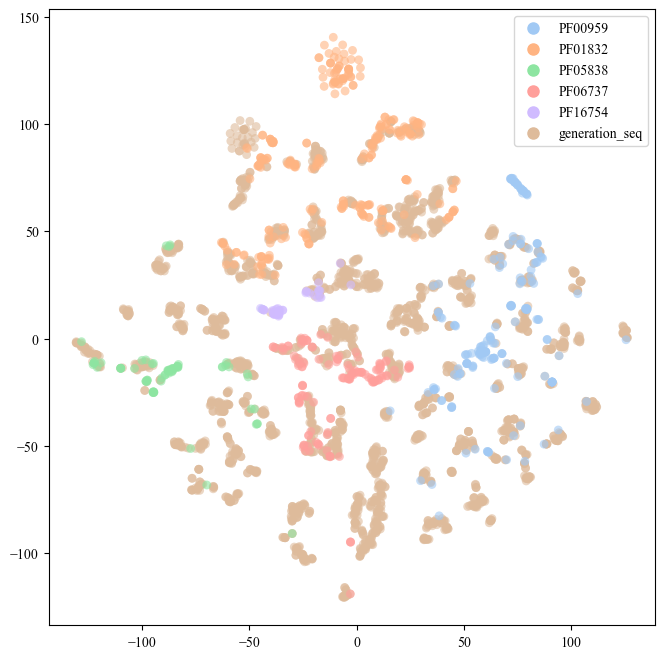

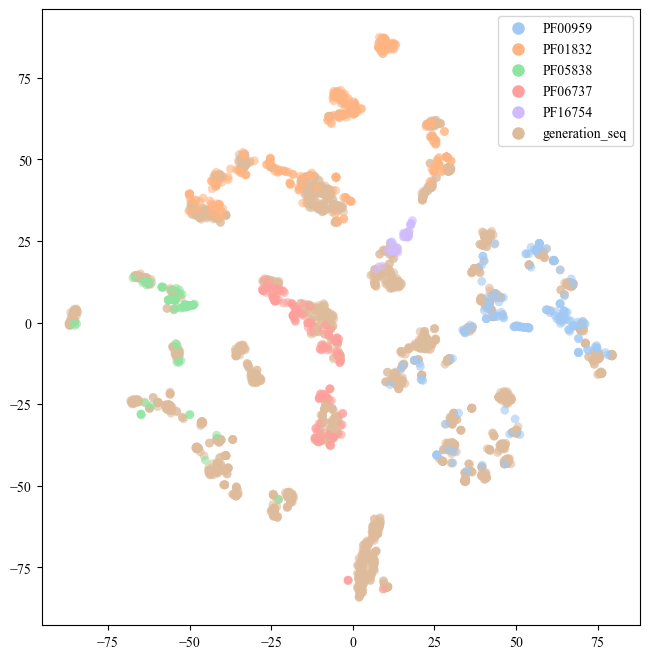

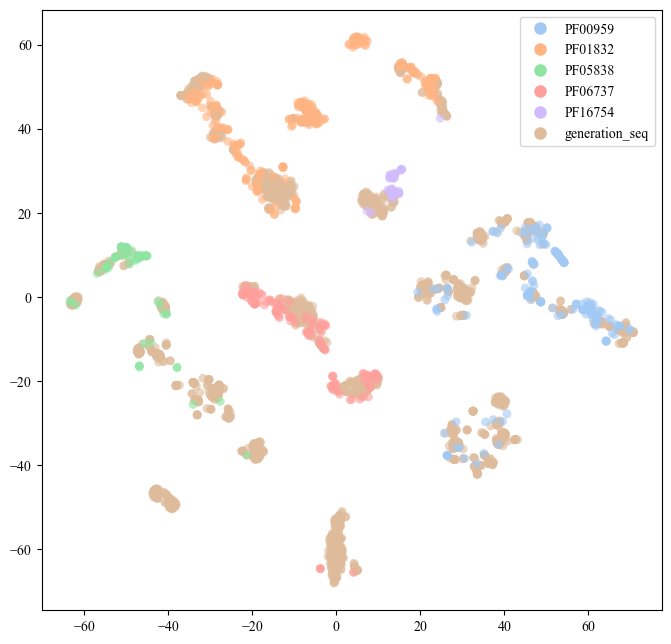

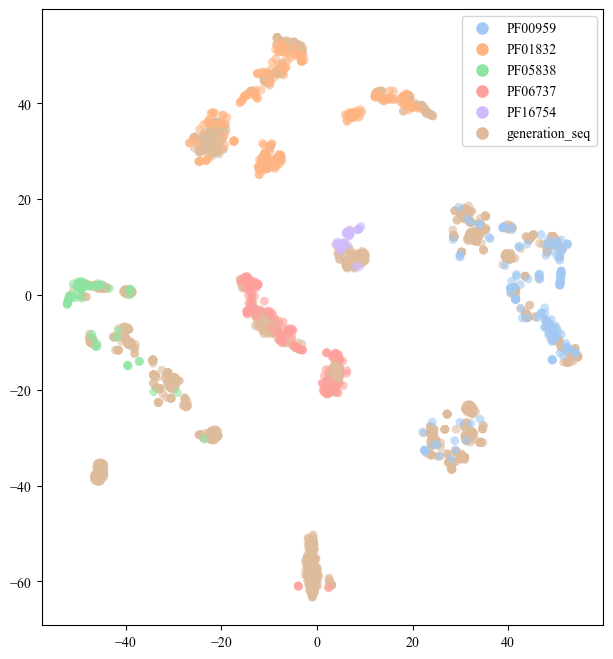

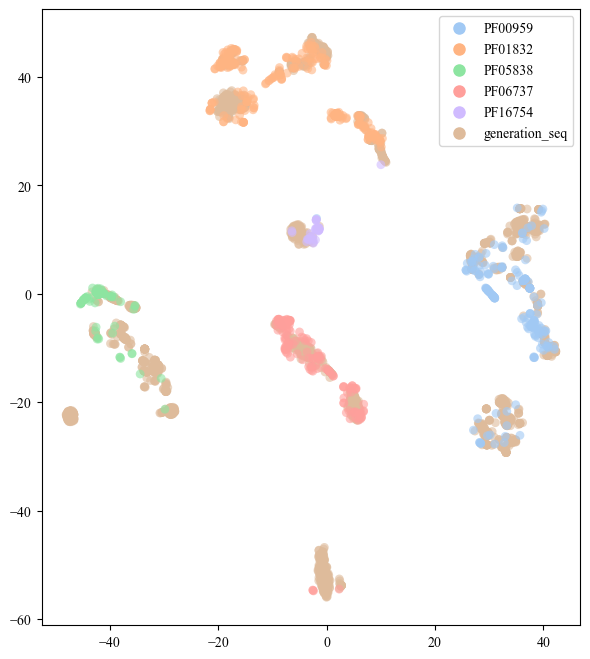

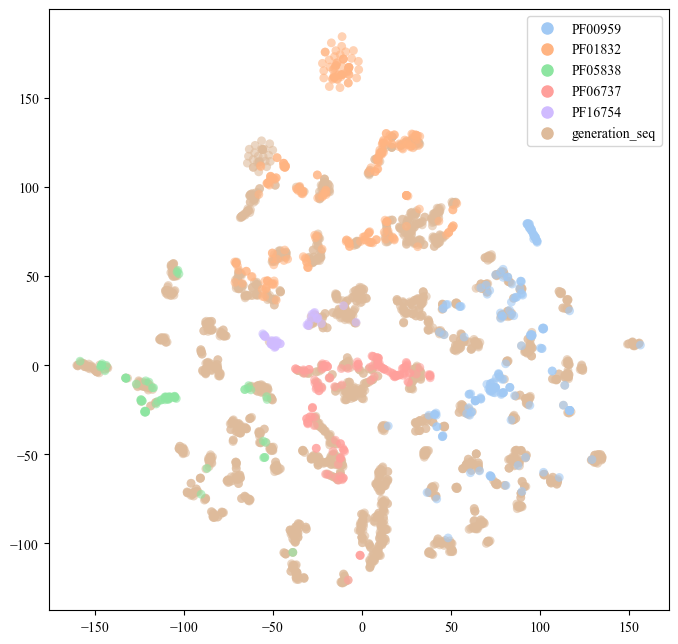

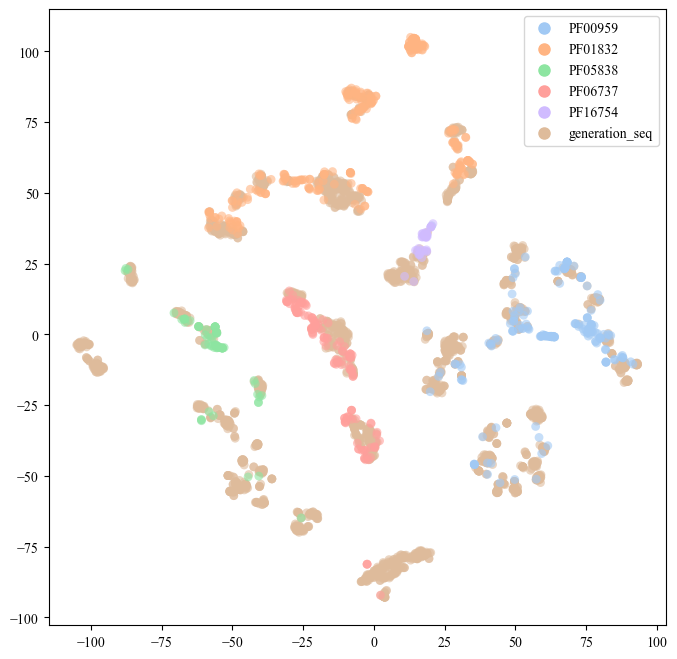

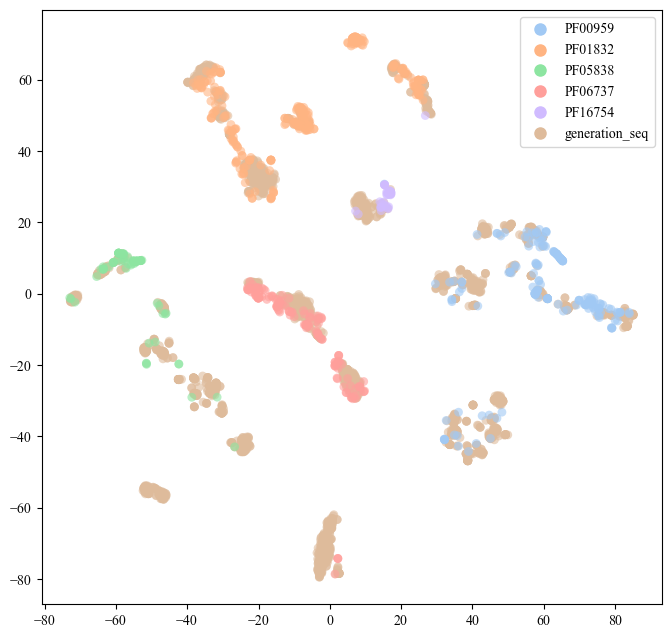

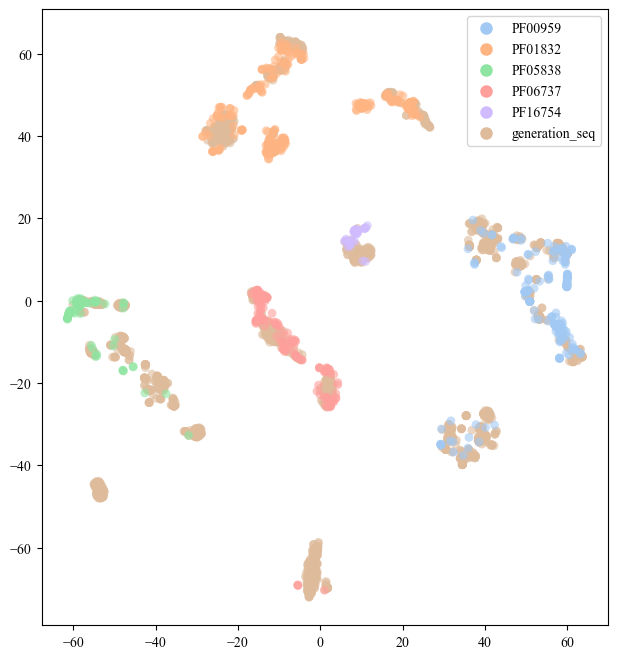

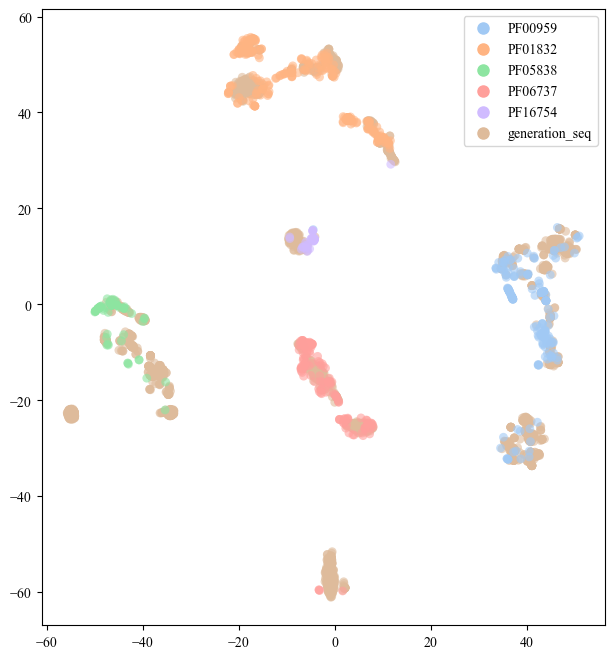

In [23]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns


def plot(x, colors, per, n_iter):
    # 选择颜色调色板
    # https://seaborn.pydata.org/generated/seaborn.color_palette.html
    palette = np.array(sns.color_palette("pastel", 6))
    # pastel, husl, and so on

    # 创建散点图
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, alpha=0.6, c=palette[colors.astype(np.int8)])

    # 添加图例
    legend_labels = ["PF00959", "PF01832", "PF05838", "PF06737", "PF16754", "generation_seq"]
    legend_handles = [plt.Line2D([], [], marker='o', markersize=8, color=c, linestyle='None') for c in palette]
    ax.legend(legend_handles, legend_labels)

    plt.savefig(f'picture/tsne_perplexity{per}_step{n_iter}.png', dpi=120)

    return f, ax

# 整个输入序列，人工序列在前，自然序列在后
sequences = np.concatenate((total_seq_generation, total_seq_natural), axis=0)
labels = np.concatenate((labels_generation, labels_natural), axis=0)

# 输出文件样本
for i, pad_seq in enumerate(sequences):
    if i > 0:
        break
    print(f"进行t-sne的单个序列样式为：{pad_seq}")
    print(f"进行t-sne的单个序列长度为：{len(pad_seq)}")
print("参与降维分析的样本数量形式" + str(sequences.shape))
print("参与t-sne的labels的shape："+str(labels.shape))

for n_iter in [2000, 5000]:
    for per in [10, 30, 50, 70, 100]:
        print("开始t-sne：" + str(datetime.now()))
        # 使用t-SNE进行降维
        tsne = TSNE(n_components=2, perplexity=per, n_iter=n_iter, init='pca')
        # # 将填充后的序列转换为NumPy数组
        # padded_sequences = np.array([eval(seq) for seq in padded_sequences], dtype=np.float32)
        X_tsne = tsne.fit_transform(sequences)
        # 将降维后的数据保存到文件中
        np.save(f"t-sne_result/tsne_{n_iter}_{per}_X.npy", X_tsne)
        np.save(f"t-sne_result/tsne_{n_iter}_{per}_labels.npy", labels)
        print("开始绘制图像：" + str(datetime.now()))
        plot(X_tsne, labels, per, n_iter)



绘图

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

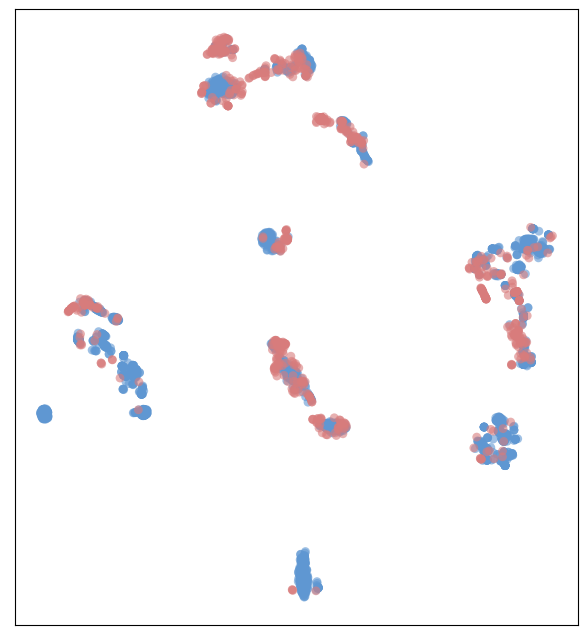

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman' # 设置全局字体

color_blue1 = '#88c4d4'
color_blue2 = '#9ac9db'
color_blue3 = '#2878b5'
color_blue4 = '#5f97d2'
color_blue = color_blue4

def plot(x, colors, per, n_iter):
    # 选择颜色调色板
    # https://seaborn.pydata.org/generated/seaborn.color_palette.html
    # palette = np.array(sns.color_palette("pastel", 6))
    # pastel, husl, and so on
    palette = np.array([
    '#D87C7C',
    '#D87C7C',
    '#D87C7C',
    '#D87C7C',
    '#D87C7C',
    color_blue
])

    # 创建散点图
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, alpha=0.6, c=palette[colors.astype(np.int8)])
    # # 修改坐标轴的字体大小
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=12)
    # 去除坐标轴的刻度
    ax.set_xticks([])
    ax.set_yticks([])

    # 添加图例
    # legend_labels = ["PF00959", "PF01832", "PF05838", "PF06737", "PF16754", "generation_seq"]
    # legend_handles = [plt.Line2D([], [], marker='o', markersize=12, color=c, linestyle='None') for c in palette]
    # ax.legend(legend_handles, legend_labels)

    plt.savefig(f'picture/tsne_perplexity{per}_step{n_iter}.png', dpi=120)

    return f, ax

X_tsne = np.load(f"t-sne_result/tsne_{n_iter}_{per}_X.npy")
labels = np.load(f"t-sne_result/tsne_{n_iter}_{per}_labels.npy")
plot(X_tsne, labels, 100, 5000)

# for n_iter in [2000, 5000]:
#     for per in [10, 30, 50, 70, 100]:
#         X_tsne = np.load(f"tsne/tsne_{n_iter}_{per}_X.npy")
#         labels = np.load(f"tsne/tsne_{n_iter}_{per}_labels.npy")
#         plot(X_tsne, labels, per, n_iter)
